# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 76.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:06<00:00, 99.1MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

phones_file = 'data/train_librispeech_10h/phones' # файл с фонемами
phones_dict = load_phones_dict(phones_file)       # {фонема: индекс фонемы}

In [4]:
# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = 'data/train_librispeech_10h/ali_phones.txt' # content -> file_name: allignment 
ali_dict = load_phone_aligment(ali_file)

In [5]:
# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)): # get the names of all files in dir_path
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


In [ ]:
# feats_dict['163-122947-0047'].shape

### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [ ]:
# phones_dict = {phone: phone_index}
# ali_dict = {file_name: [allignment]}
# feats_dict = {file_name: mfcc_array[num_of_winds, 13]}

In [6]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []             # here we save the all features of frames and index of phonem in that frame
    priors_list = [0] * len(phones_dict) # len = num_of_phonems, the count of phoneme
    for file_name in feats_dict.keys():   
        file_feats = feats_dict[file_name] # np.array, shape = (num_of_winds, 13)
        file_ali = ali_dict[file_name]     # list of phonems - allignment
        for frame in range(min(len(file_feats), len(file_ali))):
            
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))#mfcc, index of phoneme
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list) # data_list, prior probability of phonemes

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [7]:

# get iterators
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            # the features [:, :-1], the label [-1]
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [8]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:


# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1), # the last item is a phoneme index
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.5698


epoch 1:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.2585


epoch 2:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.2200


epoch 3:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1927


epoch 4:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1718


epoch 5:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1553


epoch 6:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1419


epoch 7:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1308


epoch 8:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1214


epoch 9:   0%|          | 0/4402 [00:00<?, ?it/s]

loss is: 2.1130
Time is: 4 min 50 sec


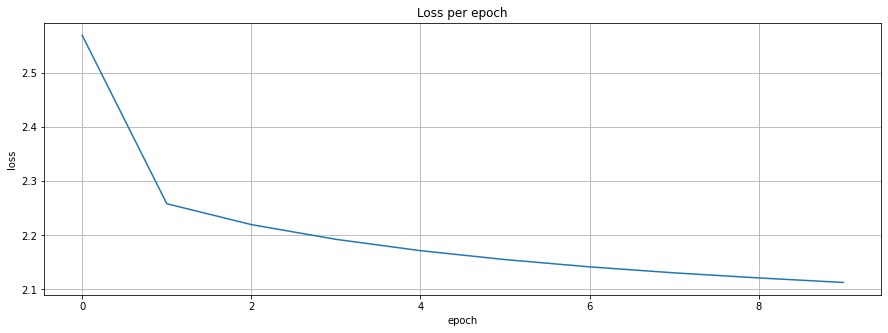

In [11]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [12]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

In [13]:

# get scores on test_data
nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr) 
        predicted_label = output.argmax().item() # prediction for frame in test_data
        correct_cnt += (predicted_label == true_label) # count the correct predicted phonemes
        class_correct[predicted_label] += (predicted_label == int(true_label)) # accuracy for predicted phoneme
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/125222 [00:00<?, ?it/s]

Total frame accuracy is 0.413

SIL: 0.97 : 21809/22554
SPN: 0.00 : 0/636
AA0: 0.00 : 0/43
AA1: 0.34 : 598/1767
AA2: 0.00 : 0/73
AE0: 0.00 : 0/48
AE1: 0.45 : 1547/3422
AE2: 0.00 : 0/73
AH0: 0.37 : 2065/5536
AH1: 0.20 : 390/1913
AH2: 0.00 : 0/48
AO0: 0.00 : 0/30
AO1: 0.38 : 686/1803
AO2: 0.00 : 0/71
AW0: 0.00 : 0/6
AW1: 0.01 : 12/1043
AW2: 0.00 : 0/47
AY0: 0.00 : 0/41
AY1: 0.11 : 307/2753
AY2: 0.00 : 0/187
B  : 0.06 : 87/1503
CH : 0.01 : 6/800
D  : 0.12 : 462/3889
DH : 0.03 : 66/1934
EH0: 0.02 : 1/63
EH1: 0.24 : 666/2753
EH2: 0.00 : 0/94
ER0: 0.21 : 534/2510
ER1: 0.05 : 49/1012
ER2: 0.00 : 0/12
EY0: 0.00 : 0/29
EY1: 0.48 : 1146/2371
EY2: 0.00 : 0/113
F  : 0.39 : 897/2306
G  : 0.01 : 5/730
HH : 0.16 : 344/2101
IH0: 0.05 : 131/2608
IH1: 0.07 : 161/2270
IH2: 0.00 : 0/94
IY0: 0.23 : 505/2155
IY1: 0.51 : 1203/2353
IY2: 0.00 : 0/60
JH : 0.01 : 4/597
K  : 0.20 : 576/2851
L  : 0.49 : 2009/4067
M  : 0.27 : 852/3116
N  : 0.51 : 2960/5859
NG : 0.10 : 127/1305
OW0: 0.00 : 0/199
OW1: 0.11 : 198/1844


### Распознавание по словарю с помощью нейронной сети

In [10]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict


In [13]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
lexicon_dict

{'NO': ['SIL', 'N', 'OW1', 'SIL'], 'YES': ['SIL', 'Y', 'EH1', 'S', 'SIL']}

In [14]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet): # расстояние до определенного вектора признака -log(псевдоправдоподобие)
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

In [ ]:
# phones_dict =   {phone: phone_index}
# ali_dict    =   {file_name: [allignment]}
# feats_dict  =   {file_name: mfcc_array[num_of_winds, 13]}

In [15]:
class State:
    def __init__(self, model, index):  
        self.model = model                     # AcousticModel
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0) # стартовое состояние (признаки: None, index = 0)
    graph = [start_state, ]      # list for graph
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state # for every word in lexicon dict the previous state is start_state
        for phone in lexicon_dict[word]:
            ###           AcousticModel(phone_name, phone_index, priors_list)
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

graph = load_graph(lexicon_dict, phones_dict, priors_list)

In [16]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [17]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [19]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=20)

  0%|          | 0/10 [00:00<?, ?it/s]

result: no_49af4432_nohash_0        ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 1.59 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [20]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> FOUR
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fb2f3242_nohash_0       ==> TWO
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: one_fc2411fe_nohash_0       ==> ONE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_ffbb695d_nohash_0      ==> FOUR
result: five_f852895b_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> SEVEN
result: seven_fd32732a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: four_fce65496_nohash_0      ==> FOUR
result: nine_fbe51750_nohash_0      ==> NINE
result: eight_da584bc0_nohash_4     ==> EIGHT
------------------------------------------------------------
WER is: 15.00%
Total time is: 15.76

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### **Ответ**:
...

Для начала определим функции:

In [19]:
def train_model(model, train_dataset, criterion, optimizer, loss_list, num_epochs = 10, batch_size=256):
    
    model.to(device)
    start = time.time()
    print("TRAINING HAS STARTED...")

    for epoch in range(num_epochs):
        running_loss = 0
        counter = 0
        for batch_xs, batch_ys in tqdm(
                                        train_dataset.next_batch(batch_size),
                                        total=train_dataset.num_batches(batch_size),
                                        desc="epoch {}".format(epoch)
                                       ):
          
            optimizer.zero_grad()
            output = model(batch_xs)

            loss = criterion(output, batch_ys)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            counter += 1


        print("Loss: {:.4f}".format((running_loss / counter)))
        
        loss_list.append(running_loss / counter)


    end = time.time()
    minutes = (end - start) // 60
    seconds = np.mod((end - start), 60)
    print("Training time: {} min {} sec".format(int(minutes), int(seconds)))

In [20]:
def plot_loss(loss_list):
    plt.rcParams['figure.figsize'] = (15.0, 5.0)
    plt.plot(loss_list)
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

In [31]:
def evaluate_model(model, eval_dataset, side_context, show_phonemes_accuracy = True):
    class_correct = [0 for x in range(len(phones_dict.keys()))]
    class_total = [0 for x in range(len(phones_dict.keys()))]

    model.cpu()

    with torch.no_grad():
        correct_cnt = 0
        for ftr, true_label in tqdm(zip(eval_dataset.valid[:, :-1], eval_dataset.valid[:, -1]), total=eval_dataset.valid.shape[0]):
            ftr = torch.from_numpy(ftr).float()
            output = model.forward(ftr)
            predicted_label = output.argmax().item()
            correct_cnt += (predicted_label == true_label)
            class_correct[predicted_label] += (predicted_label == int(true_label))
            class_total[int(true_label)] += 1

    print("Side_context is: {} ".format(side_context))        
    print("Total frame accuracy is {:.3f}\n".format(correct_cnt / dataset.valid.shape[0]))
    print()

    if show_phonemes_accuracy:
        for idx, phone in enumerate(phones_dict.keys()):
            if class_total[idx]:
                print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                            class_correct[idx], class_total[idx]))

In [22]:
def get_concat_frames(data: np.array, side_context=5):
    
    pad_data = np.pad(data, pad_width=((side_context, side_context), (0, 0)), mode="edge")
    features = []
    
    for frame in range(side_context, len(pad_data) - side_context):

        frames_idx = [neighbour_idx for neighbour_idx in range(frame - side_context, frame + side_context + 1)]
        features.append(np.concatenate([pad_data[idx] for idx in frames_idx]))
    
    features = np.asarray(features)
    return features

In [23]:
# объединение кадров признаков с соответствующими им фонемами:
def combine_data(ali_dict, feats_dict, phones_dict, side_context=5):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]  # MFCC features for file frames
        file_feats = get_concat_frames(file_feats, side_context=side_context)
        file_ali = ali_dict[file_name]  # phonemes for file frames

        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1

    return data_list, np.array(priors_list) / max(sum(priors_list), 1)


data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context = 5)
data_list = np.random.permutation(data_list)

In [ ]:

data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context = 5)
data_list = np.random.permutation(data_list)
dataset = CommonDataSet(data_list, device)

net = MyNNet(input_dim=(data_list[0].shape[0] - 1), output_dim=len(phones_dict.keys())).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

train_model(net, dataset, criterion, optimizer, loss_list, num_epochs = 10, batch_size=512)

TRAINING HAS STARTED...


epoch 0:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 2.3080


epoch 1:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.7003


epoch 2:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.5973


epoch 3:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.5334


epoch 4:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.4866


epoch 5:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.4491


epoch 6:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.4185


epoch 7:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.3927


epoch 8:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.3704


epoch 9:   0%|          | 0/2201 [00:00<?, ?it/s]

Loss: 1.3507
Training time: 4 min 22 sec


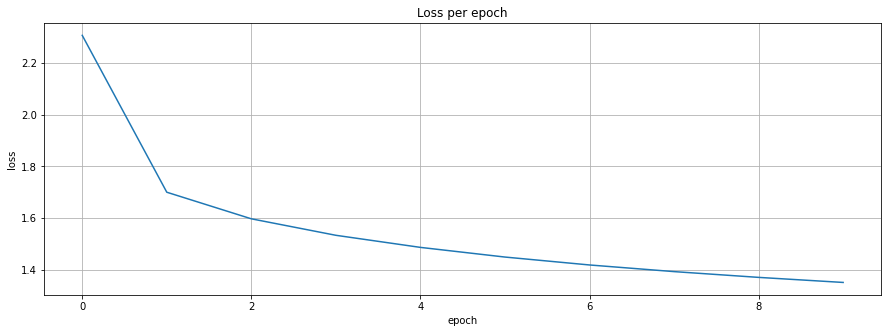

In [ ]:
plot_loss(loss_list)

In [ ]:
evaluate_model(net, dataset, side_context = 5, show_phonemes_accuracy  = True)

  0%|          | 0/125222 [00:00<?, ?it/s]

For side_context 5: 
	 total frame accuracy is 0.594


SIL: 0.97 : 21719/22367
SPN: 0.00 : 0/642
AA0: 0.00 : 0/42
AA1: 0.45 : 813/1796
AA2: 0.00 : 0/71
AE0: 0.00 : 0/53
AE1: 0.47 : 1569/3315
AE2: 0.00 : 0/99
AH0: 0.51 : 2760/5463
AH1: 0.30 : 570/1931
AH2: 0.00 : 0/47
AO0: 0.00 : 0/30
AO1: 0.47 : 871/1837
AO2: 0.00 : 0/63
AW0: 0.00 : 0/9
AW1: 0.41 : 422/1037
AW2: 0.09 : 4/47
AY0: 0.00 : 0/43
AY1: 0.65 : 1726/2640
AY2: 0.00 : 0/185
B  : 0.34 : 519/1517
CH : 0.42 : 355/842
D  : 0.37 : 1433/3885
DH : 0.51 : 972/1898
EH0: 0.00 : 0/54
EH1: 0.42 : 1184/2846
EH2: 0.01 : 1/81
ER0: 0.41 : 1076/2621
ER1: 0.35 : 360/1034
ER2: 0.00 : 0/10
EY0: 0.00 : 0/34
EY1: 0.63 : 1473/2330
EY2: 0.00 : 0/126
F  : 0.55 : 1270/2300
G  : 0.32 : 248/776
HH : 0.48 : 1014/2116
IH0: 0.27 : 698/2579
IH1: 0.33 : 737/2240
IH2: 0.00 : 0/76
IY0: 0.48 : 1040/2186
IY1: 0.57 : 1304/2303
IY2: 0.02 : 1/60
JH : 0.34 : 216/631
K  : 0.51 : 1503/2931
L  : 0.67 : 2858/4255
M  : 0.48 : 1498/3145
N  : 0.70 : 4040/5773
NG : 0.37 : 474/1

In [ ]:
lexicon_file = "data/lexicon_yes_no.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

records_data_dict = {
    key: get_concat_frames(value, side_context=5)
    for key, value in records_data_dict.items()
}

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=20)

  0%|          | 0/10 [00:00<?, ?it/s]

result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.02 sec
------------------------------------------------------------


In [ ]:
lexicon_file = "data/lexicon_digits.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

records_data_dict = {
    key: get_concat_frames(value, side_context=5)
    for key, value in records_data_dict.items()
}

run_recognizer( records_data_dict, graph, net.cpu(), beam_threshold=50)

  0%|          | 0/20 [00:00<?, ?it/s]

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fb2f3242_nohash_0       ==> TWO
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: one_fc2411fe_nohash_0       ==> ONE
result: three_feb1d305_nohash_0     ==> THREE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_ffbb695d_nohash_0      ==> FOUR
result: five_f852895b_nohash_0      ==> FIVE
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: four_fce65496_nohash_0      ==> FOUR
result: nine_fbe51750_nohash_0      ==> NINE
result: eight_da584bc0_nohash_4     ==> EIGHT
------------------------------------------------------------
WER is: 0.00%
Total time is: 12.04 sec


## Результаты:

В качестве `side_context` брались значения `[1, 2, 3, 4, 5]`, наилучший результат получился для значения `side_context = 5`: `total_frame_accuracy = 0.594`. Для `yes_no` значение `wer` снизилось с 10% до 0%. Для `digits` также `wer` с 15% упал до 0%. 

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Ответ**:
...

In [43]:
class DeepNet_3(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim):
        super(DeepNet_3, self).__init__()

        self.lin_1 = nn.Linear(input_dim, hidden_dim_1)
        self.elu_1 = nn.ELU()
        self.lin_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.elu_2 = nn.ELU()
        self.lin_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.elu_3 = nn.ELU()
        self.lin_4 = nn.Linear(hidden_dim_3, hidden_dim_4)
        self.elu_4 = nn.ELU()
        self.lin_out = nn.Linear(hidden_dim_4, output_dim)

    def forward(self, x):
        x = self.elu_1(self.lin_1(x))
        x = self.elu_2(self.lin_2(x))
        x = self.elu_3(self.lin_3(x))
        x = self.elu_4(self.lin_4(x))

        out = self.lin_out(x)
        return out


net = DeepNet_3(
    input_dim = data_list[0].shape[0] - 1,
    hidden_dim_1 = 1024,
    hidden_dim_2 = 1024,
    hidden_dim_3 = 512,
    hidden_dim_4 = 512,
    output_dim = len(phones_dict.keys()),
).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, weight_decay=5e-4)

loss_list = []

In [44]:
data_list, priors_list = combine_data(ali_dict, feats_dict, phones_dict, side_context=5)
data_list = np.random.permutation(data_list)

dataset = CommonDataSet(data_list, device)

criterion = nn.CrossEntropyLoss()

In [45]:
train_model(net, dataset, criterion, optimizer, loss_list, num_epochs = 10, batch_size=512)

TRAINING HAS STARTED...


epoch 0:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 1.5646


epoch 1:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 1.2623


epoch 2:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 1.1604


epoch 3:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 1.0887


epoch 4:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 1.0297


epoch 5:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 0.9784


epoch 6:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 0.9317


epoch 7:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 0.8891


epoch 8:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 0.8504


epoch 9:   0%|          | 0/2261 [00:00<?, ?it/s]

Loss: 0.8148
Training time: 1 min 23 sec


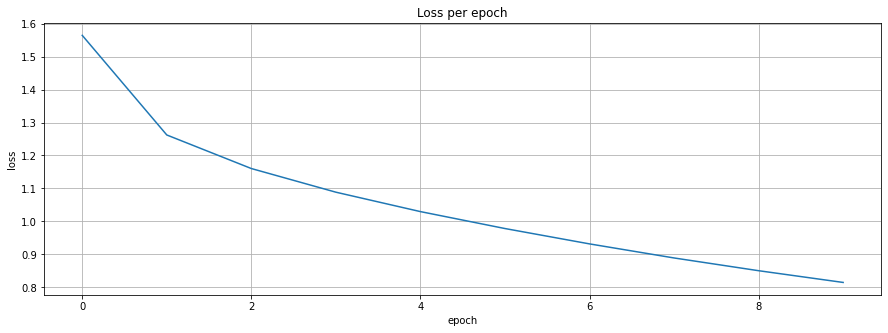

In [46]:
plot_loss(loss_list)

In [47]:
evaluate_model(net, dataset, side_context = 5, show_phonemes_accuracy  = False)

  0%|          | 0/128635 [00:00<?, ?it/s]

Side_context is: 5 
Total frame accuracy is 0.692




## Ответ:

Были выбраны разные архитектуры для моделей. Наилучший результат получается для модели (приведенной выше), где в качестве функции активации берутся `ELU`. Для функции активаций `ReLU` и `LeakyRelu` получаются одинаковые результаты, как правило на 1-2 % ниже чем для `ELU`. Также увеличение размерности слоев приводит к росту результата, например увеличение размерности каждого слоя в 2 раза (с 512 до 1024) приводит к росту почти на 3-4 %. Во всех экспериментах для `side_context` бралось значение равное 5, поскольку при этом значении был получен лучший результат в первом задании.   